# Dataset
I am going to use python and further libraries to analyse the sentiment reviews, I am going to use a preconstructed annotated dataset that contains 41 399 rows.

I did some preprocessing on this data, which can be found in `find_root_sentences.py` and `divide_on_sets.py` files. The result of that is addition of three columns:
- `words` (describing words number (int))
- `roots` (describing if a sample is a root sentence, it is not a subsentence of different sentence in set (bool))
- `set_type` (describing which set it is part of {training set: 0, validation set = 1, test set: 2})

In this step I did also small cleaning, I converted the words to lower cases and removed all non-letter characters. These elements are very common and they do not provide enough semantic information for the task.

In [1245]:
import pandas as pd

In [1283]:
def ingest_train():
    data = pd.read_csv('./divided_on_sets.csv', encoding='utf-8', sep='\t')
    
    data = data[data.sentiment.isnull() == False]
    data['sentiment'] = data['sentiment'].map(int)
    
    data = data[data['tokens'].isnull() == False]
    data['tokens'] = data['tokens'].map(eval)
    
    data = data[data.roots.isnull() == False]
    data['roots'] = data['roots'].map(bool)
    
    data = data[data.words.isnull() == False]
    data['words'] = data['words'].map(int)
    data = data[data.words > 0]
    
    data = data[data.set_type.isnull() == False]
    data['set_type'] = data['set_type'].map(int)
    
    data.reset_index(inplace=True)
    data.drop('index', axis=1, inplace=True)
    data.drop('id', axis=1, inplace=True)
    return data

In [1284]:
train = ingest_train()

In [1285]:
train.describe()

sentiment         words      set_type
count  35966.000000  35966.000000  35966.000000
mean       0.036479      4.027415      0.332453
std        0.521420      5.334304      0.678478
min       -1.000000      1.000000      0.000000
25%        0.000000      1.000000      0.000000
50%        0.000000      2.000000      0.000000
75%        0.000000      5.000000      0.000000
max        1.000000     79.000000      2.000000

In [1322]:
train.head()

tokens  sentiment  words  roots  \
0                                             sam          0      1  False   
1                                      sam burger          0      2  False   
2                            sam burger był dobry          1      4  False   
3                                           dobry          1      1  False   
4  sam burger był dobry oczywiście jadła m lepsze          1      8  False   

   set_type  
0         0  
1         2  
2         2  
3         0  
4         2

# Data visualization
Before proceeding to the classification step, I did some visualization of my textual data. The words cloud is a best choice for this matter. It displays a list of words, the importance of each beeing shown with font size or color. This format is useful for quickly perceiving the most prominent terms.

For this data viz, I used the python library wordcloud.

In [1287]:
import matplotlib.pyplot as plt
plt.style.use('fivethirtyeight')

%matplotlib inline
%config InlineBackend.figure_format = 'retina'
from wordcloud import WordCloud, STOPWORDS

def show_word_cloud(sentiment_val, colors):
    data = train[train.sentiment == sentiment_val]
    words = []
    for t in data.tokens:
        words += t
    words_string = " ".join(words)
    wordcloud = WordCloud(width=1600, 
                          height=800, 
                          max_font_size=200, 
                          colormap=colors, 
                          background_color='white').generate(words_string)
    plt.figure(figsize=(12,10))
    plt.imshow(wordcloud, interpolation="bilinear")
    plt.axis("off")
    plt.show()

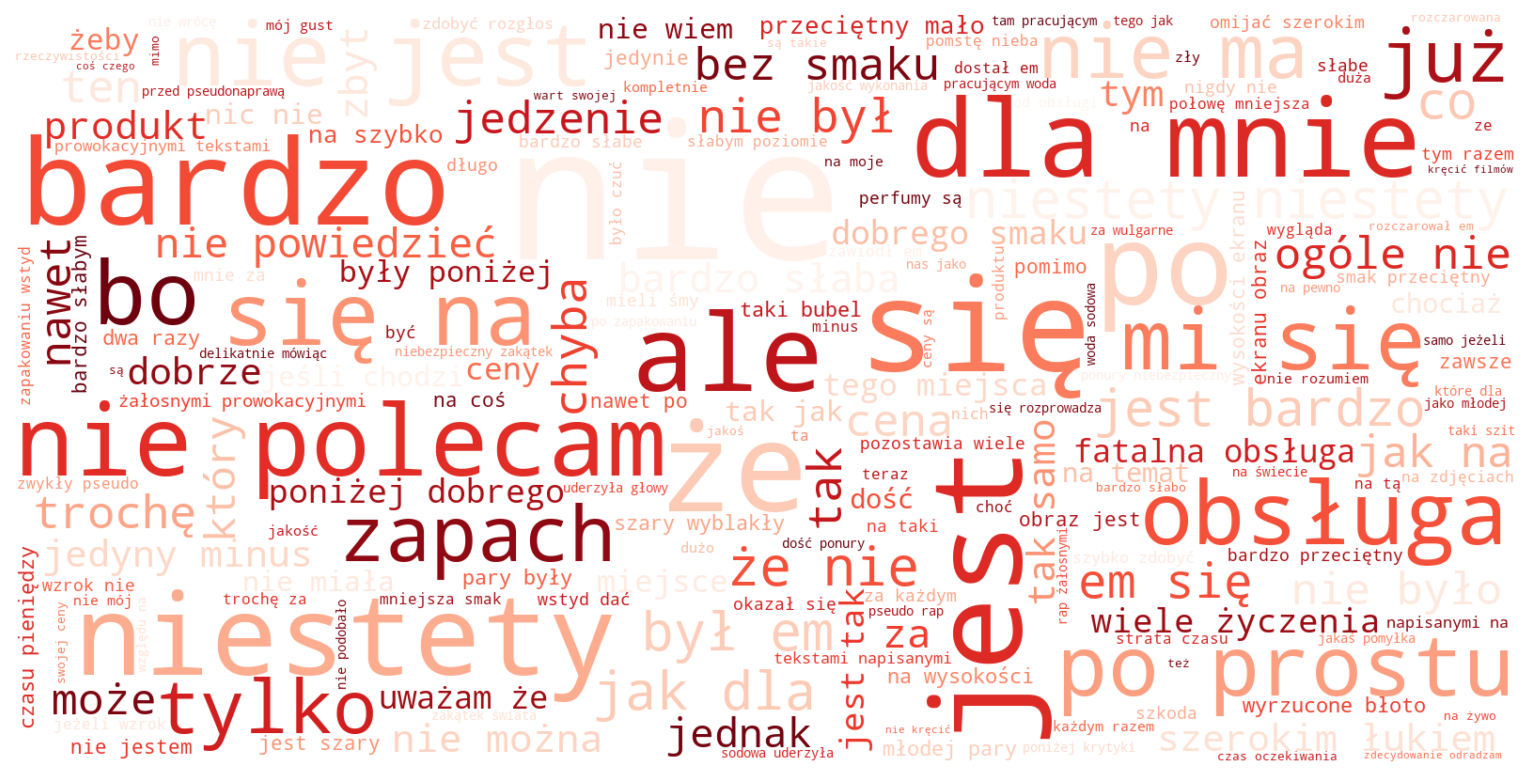

In [1288]:
show_word_cloud(-1, 'Reds')

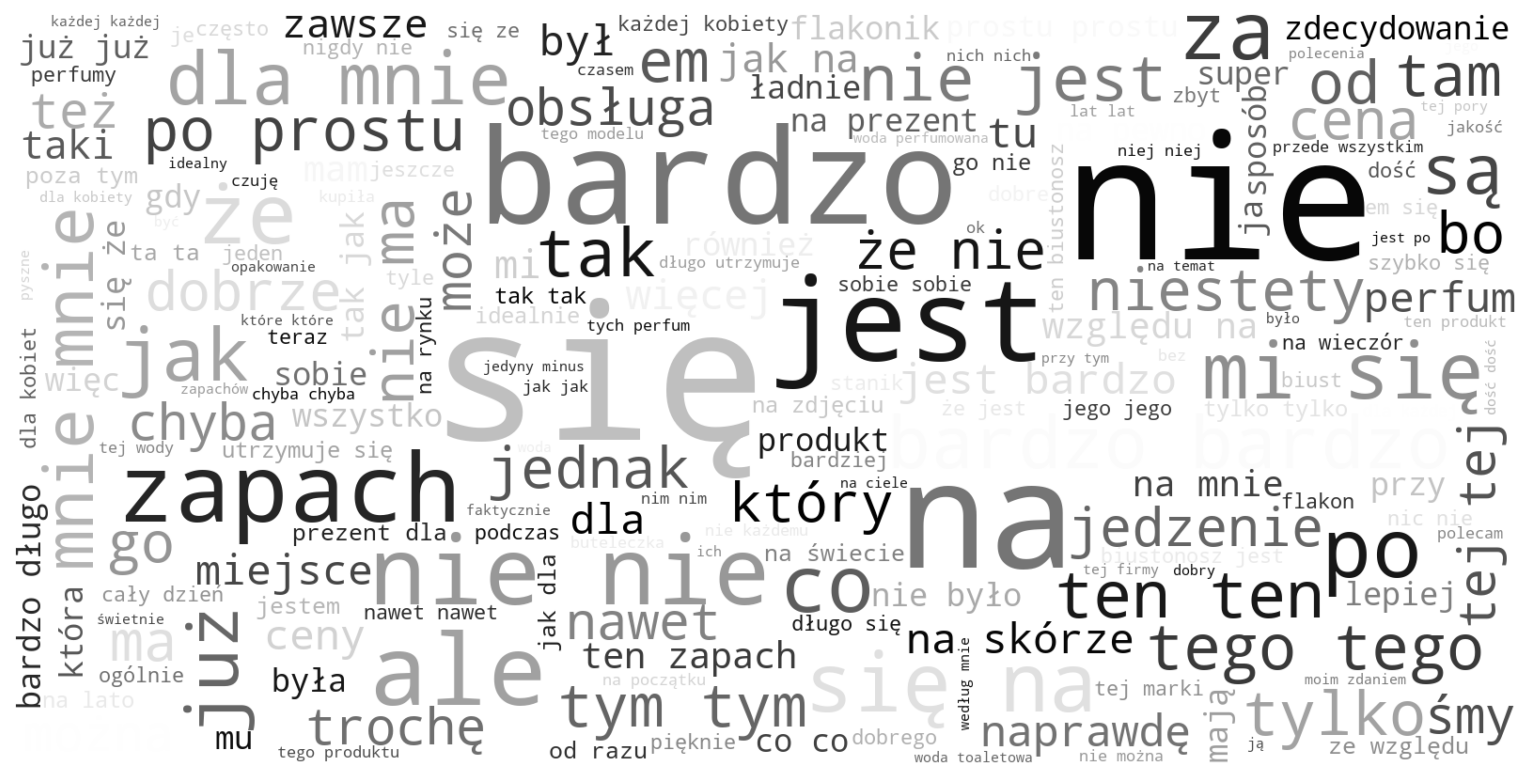

In [1289]:
show_word_cloud(0, 'gray')

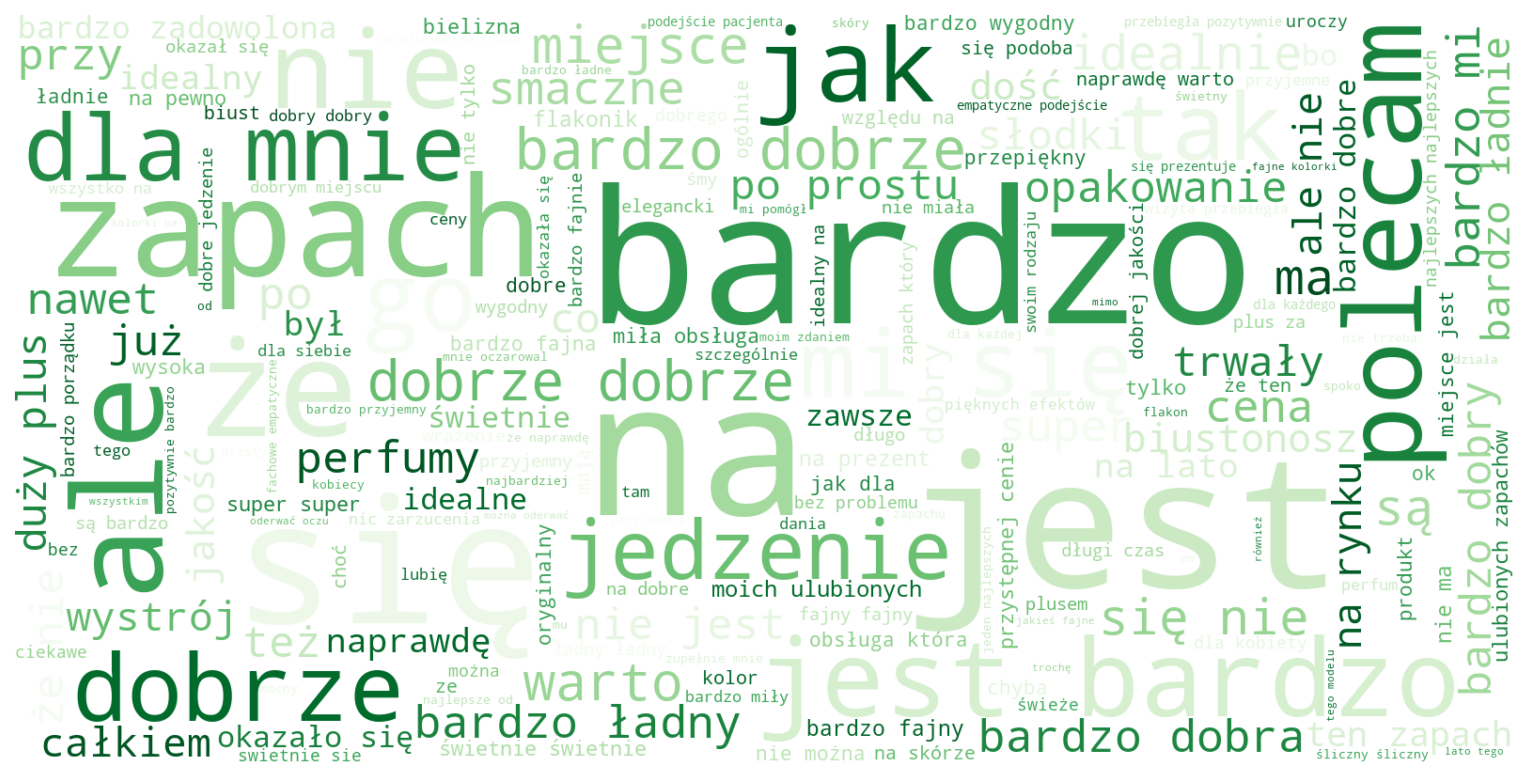

In [1290]:
show_word_cloud(1, 'Greens')

We can see some netural words in big size, "jest", "się", "bardzo" but words like "dobrze", "polecam", "ładny" are relevant for positive words and "niestety", "trochę" for negative words.

# Building the models
Before proceeding to the training phase, I split the data into training, validation and test set. I used earlier preparied `set_type` column.

In [1291]:
from sklearn.preprocessing import label_binarize

train['tokens'] = train['tokens'].map(lambda x: " ".join(x))
binary_sentiment = label_binarize(train['sentiment'], classes=[-1, 0, 1])
print(binary_sentiment[0:5])

Series([], Name: tokens, dtype: object)
[[0 1 0]
 [0 1 0]
 [0 0 1]
 [0 0 1]
 [0 0 1]]


In [1355]:
x_train = train.tokens[train['set_type'] == 0]
x_validation = train.tokens[train['set_type'] == 1]
x_test = train.tokens[train['set_type'] == 2]

y_train = binary_sentiment[train['set_type'] == 0]
y_validation = binary_sentiment[train['set_type'] == 1]
y_test = binary_sentiment[train['set_type'] == 2]

y_sentiment_train = train.sentiment[train['set_type'] == 0]
y_sentiment_validation = train.sentiment[train['set_type'] == 1]
y_sentiment_test = train.sentiment[train['set_type'] == 2]
    
print("train:     ", len(x_train), 
      " classes:", np.sum(y_train, axis=0))  
print("validation:", len(x_validation), 
      "  classes:", np.sum(y_validation, axis=0))
print("test:      ", len(x_test),
      "  classes:", np.sum(y_test, axis=0))

train:      28296  classes: [ 2820 21394  4082]
validation: 3383   classes: [ 625 2064  694]
test:       4287   classes: [ 812 2682  793]


In [1350]:
trace1 = go.Bar(
    x=['train', 'validation', 'test'],
    y=[2820, 625, 812],
    name='negative'
)

trace2 = go.Bar(
    x=['train', 'validation', 'test'],
    y=[21394,2064, 2684],
    name='neutral'
)
trace3 = go.Bar(
    x=['train', 'validation', 'test'],
    y=[4082, 694, 793],
    name='positive'
)

data = [trace1, trace2, trace3]
layout = go.Layout(
    barmode='group'
)

fig = go.Figure(data=data, layout=layout)
py.iplot(fig, filename='grouped-bar')

We can see that classes are not equally distribiuted. This information will be very important in further research.
# Features Extraction
In this part, I will use a feature extraction technique called Tfidf vectorizer of 100,000 features including up to trigram. This technique is a way to convert textual data to numeric form.

In the below function, I will use a custom function that reports validation accuracy and the average precision_recall.

In [1293]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import average_precision_score
import seaborn as sn
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix
n_classes = 3

def multi_class_precision_recall(y_test, y_pred):
    # For each class
    precision = dict()
    recall = dict()
    average_precision = dict()
    for i in range(n_classes):
        precision[i], recall[i], _ = precision_recall_curve(y_test[:, i],
                                                            y_pred[:, i])
        average_precision[i] = average_precision_score(y_test[:, i], y_pred[:, i])

    # A "micro-average": quantifying score on all classes jointly
    precision["micro"], recall["micro"], _ = precision_recall_curve(y_test.ravel(), y_pred.ravel())
    return precision["micro"], recall["micro"]

def multi_class_roc(y_test, y_pred):
    fpr = dict()
    tpr = dict()
    roc_auc = dict()
    for i in range(n_classes):
        fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
        roc_auc[i] = auc(fpr[i], tpr[i])

    # Compute micro-average ROC curve and ROC area
    fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
    return fpr["micro"], tpr["micro"]

def multi_class_confusion_matrix(y_test, y_pred):
    cm = confusion_matrix([np.sum(np.array([-1,0,1]) * np.array(x).T) for x in y_test], 
                         [np.sum(np.array([-1,0,1]) * np.array(x).T) for x in y_pred])
    # Normalize
    cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    
    # Visualize confiusion matrix as heatmap
    df_cm = pd.DataFrame(cm, index = ["-1", "0", "1"],
                  columns = ["-1", "0", "1"])
    plt.figure(figsize = (5,5))
    sn.heatmap(df_cm, annot=True, fmt='f')
    
    # Improve heatmap dispaly
    bottom, top = plt.ylim()
    bottom += 0.5
    top -= 0.5
    plt.ylim(bottom, top)
    plt.show()

In [1294]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import label_binarize
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.metrics import accuracy_score, precision_recall_curve, average_precision_score, roc_curve, auc
import numpy as np
from time import time

def acc_summary(pipeline, x_train, y_train, x_test, y_test):
    
    sentiment_fit = pipeline.fit(x_train, y_train)
    y_pred = sentiment_fit.predict(x_test)
  
    #Compute the accuracy
    accuracy = accuracy_score(y_test, y_pred)
    #Compute the precision and recall
    precision, recall = multi_class_precision_recall(y_test, y_pred)
    #Compute the average precision
    average_precision = average_precision_score(y_test, y_pred)
  
    fpr, tpr = multi_class_roc(y_test, y_pred)
    print('Average precision-recall score: {0:0.2f}'.format(average_precision))
    print ("accuracy score: {0:.2f}%".format(accuracy*100))
    multi_class_confusion_matrix(y_test, y_pred)
    print ("-"*80)
    return accuracy, precision, recall, average_precision, fpr, tpr

In [1332]:
vec = TfidfVectorizer(min_df=0)
vec.set_params(stop_words=None, max_features=10000000, ngram_range=(1, 3))
vec.fit(x_train, y_train)

TfidfVectorizer(analyzer='word', binary=False, decode_error='strict',
                dtype=<class 'numpy.float64'>, encoding='utf-8',
                input='content', lowercase=True, max_df=1.0,
                max_features=10000000, min_df=0, ngram_range=(1, 3), norm='l2',
                preprocessor=None, smooth_idf=True, stop_words=None,
                strip_accents=None, sublinear_tf=False,
                token_pattern='(?u)\\b\\w\\w+\\b', tokenizer=None, use_idf=True,
                vocabulary=None)

In [1349]:
print("Number of features created:", len(vec.vocabulary_.keys()))
print("Example of features:")
list(vec.vocabulary_.keys())[0:20]

Number of features created: 40060
Example of features:


['sam',
 'dobry',
 'oczywiście',
 'lepsze',
 'mięso',
 'na',
 'pewno',
 'na pewno',
 'nie',
 'średnio',
 'wysmażone',
 'mięso średnio',
 'średnio wysmażone',
 'mięso średnio wysmażone',
 'bardzo',
 'soczyste',
 'bardzo soczyste',
 'aromatyczne',
 'po',
 'prostu']

Validation result for Logistic Regression
LogisticRegression(C=1.0, class_weight='balanced', dual=False,
                   fit_intercept=True, intercept_scaling=1, l1_ratio=None,
                   max_iter=1000, multi_class='auto', n_jobs=None, penalty='l2',
                   random_state=None, solver='lbfgs', tol=0.0001, verbose=0,
                   warm_start=False)
Average precision-recall score: 0.47
accuracy score: 63.41%


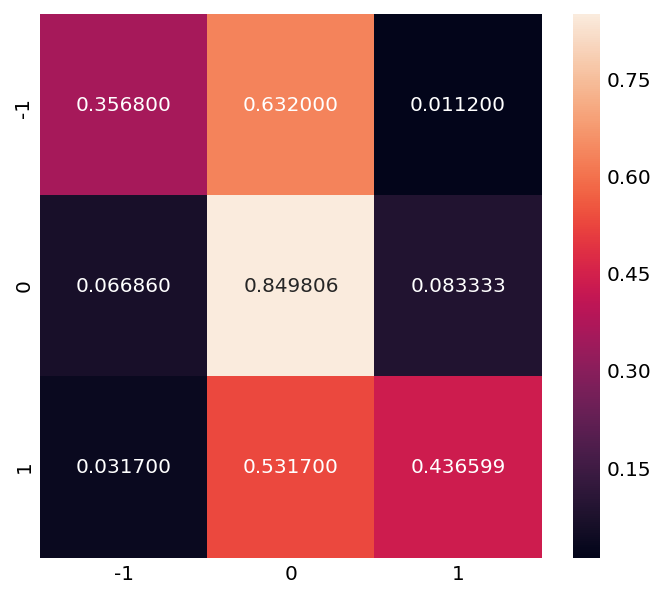

--------------------------------------------------------------------------------
Validation result for Linear SVC
LinearSVC(C=1.0, class_weight='balanced', dual=True, fit_intercept=True,
          intercept_scaling=1, loss='squared_hinge', max_iter=1000,
          multi_class='ovr', penalty='l2', random_state=None, tol=0.0001,
          verbose=0)
Average precision-recall score: 0.47
accuracy score: 65.68%


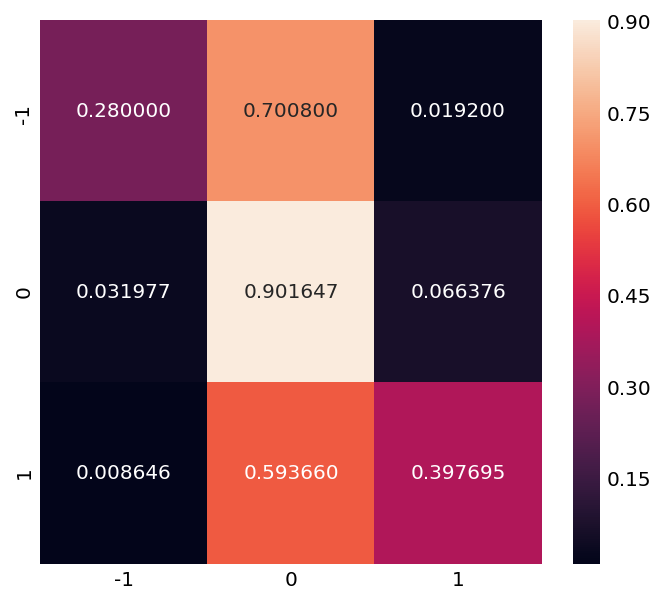

--------------------------------------------------------------------------------
Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
              

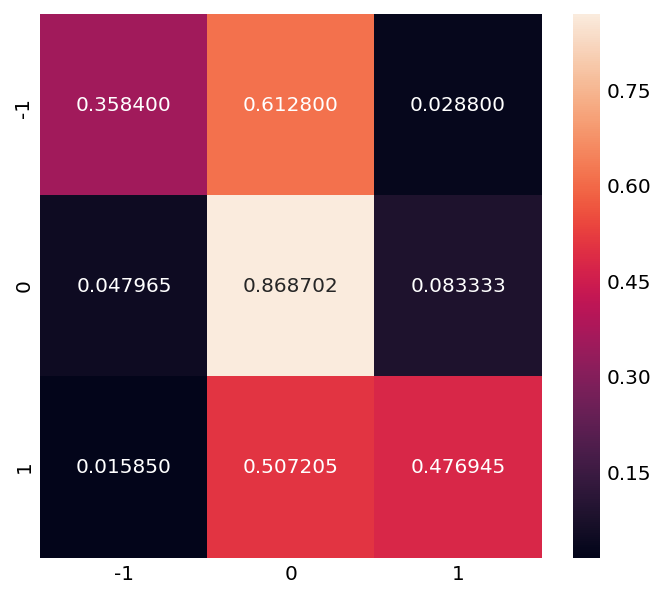

--------------------------------------------------------------------------------
Validation result for Multinomial NB
MultinomialNB(alpha=1.0, class_prior=None, fit_prior=True)
Average precision-recall score: 0.35
accuracy score: 61.78%


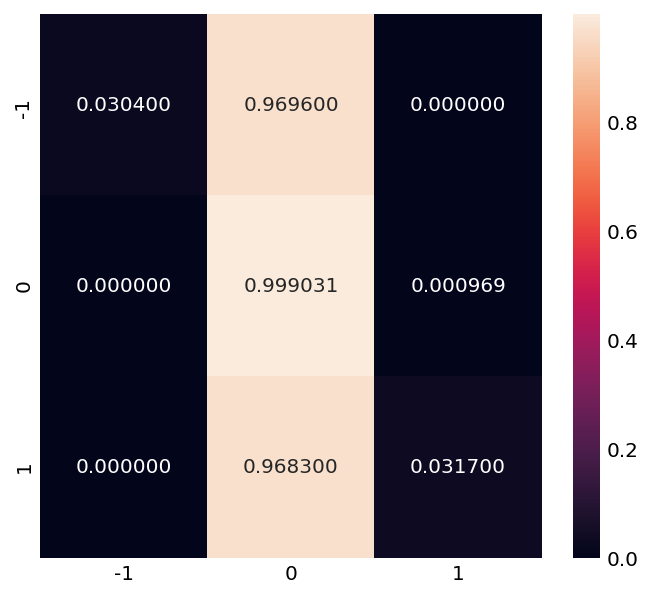

--------------------------------------------------------------------------------
Validation result for Bernoulli NB
BernoulliNB(alpha=1.0, binarize=0.0, class_prior=None, fit_prior=True)
Average precision-recall score: 0.37
accuracy score: 60.66%


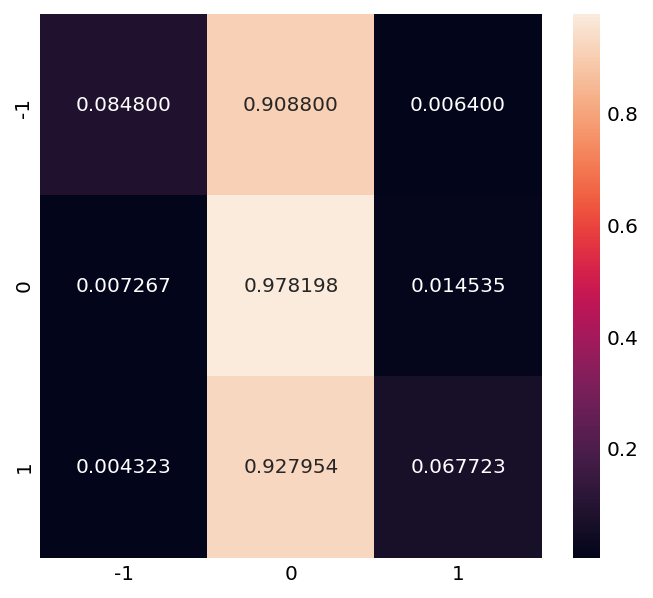

--------------------------------------------------------------------------------
Validation result for Ridge Classifier
RidgeClassifier(alpha=1.0, class_weight='balanced', copy_X=True,
                fit_intercept=True, max_iter=None, normalize=False,
                random_state=None, solver='auto', tol=0.001)
Average precision-recall score: 0.41
accuracy score: 30.65%


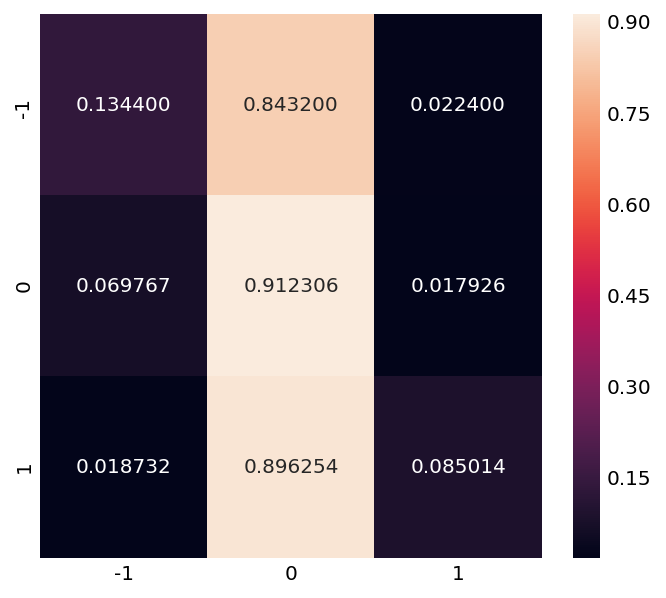

--------------------------------------------------------------------------------
Validation result for AdaBoost
AdaBoostClassifier(algorithm='SAMME.R', base_estimator=None, learning_rate=1.0,
                   n_estimators=50, random_state=None)
Average precision-recall score: 0.41
accuracy score: 59.53%


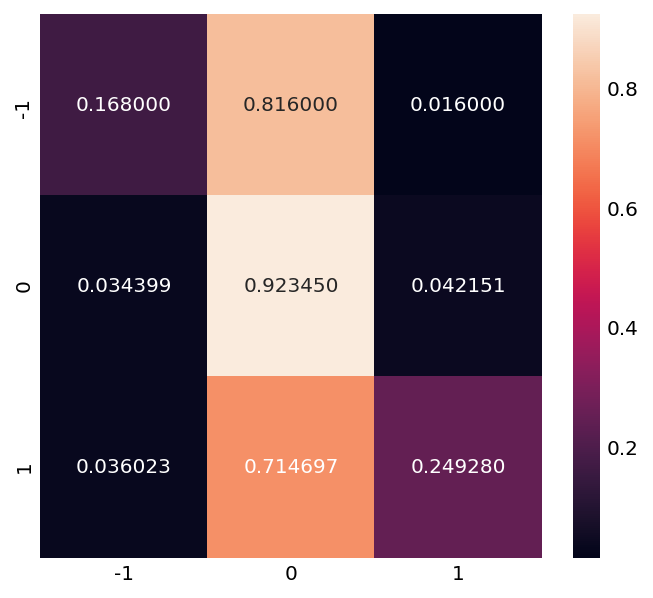

--------------------------------------------------------------------------------
Validation result for RandomForest
RandomForestClassifier(bootstrap=True, ccp_alpha=0.0, class_weight=None,
                       criterion='gini', max_depth=None, max_features='auto',
                       max_leaf_nodes=None, max_samples=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=None,
                       verbose=0, warm_start=False)
Average precision-recall score: 0.44
accuracy score: 64.74%


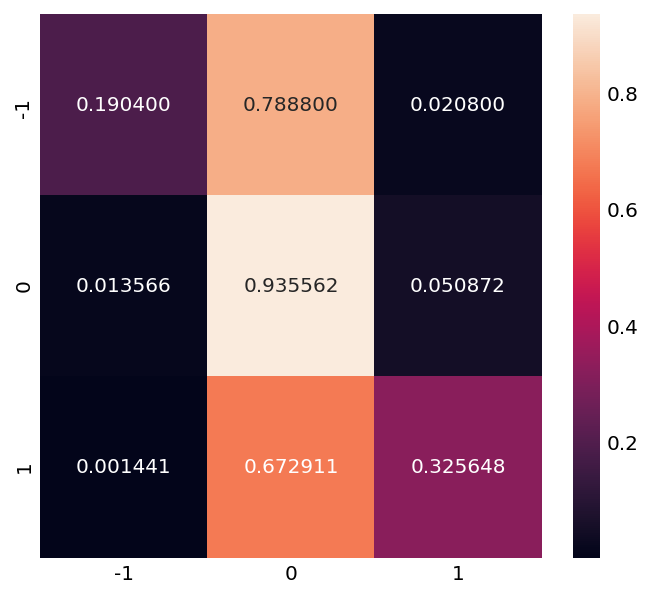

--------------------------------------------------------------------------------
Validation result for Perceptron
Perceptron(alpha=0.0001, class_weight='balanced', early_stopping=False,
           eta0=1.0, fit_intercept=True, max_iter=1000, n_iter_no_change=5,
           n_jobs=None, penalty=None, random_state=0, shuffle=True, tol=0.001,
           validation_fraction=0.1, verbose=0, warm_start=False)
Average precision-recall score: 0.44
accuracy score: 62.46%


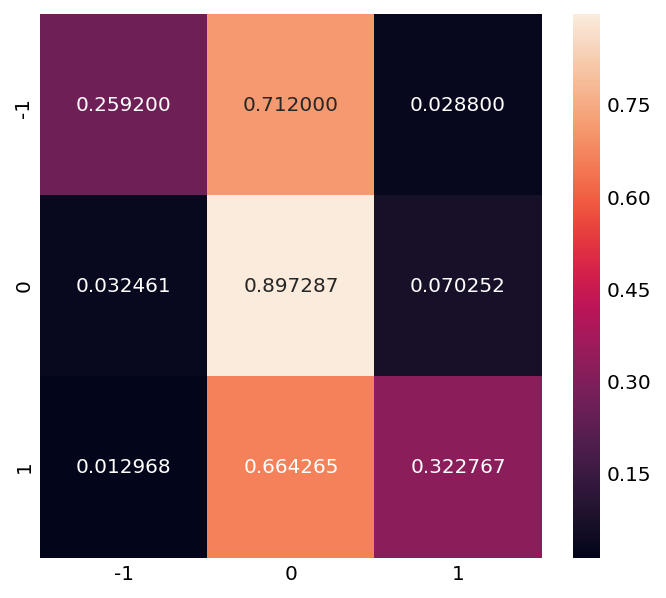

--------------------------------------------------------------------------------
Validation result for Passive-Aggresive
PassiveAggressiveClassifier(C=1.0, average=False, class_weight='balanced',
                            early_stopping=False, fit_intercept=True,
                            loss='hinge', max_iter=1000, n_iter_no_change=5,
                            n_jobs=None, random_state=None, shuffle=True,
                            tol=0.001, validation_fraction=0.1, verbose=0,
                            warm_start=False)
Average precision-recall score: 0.44
accuracy score: 64.20%


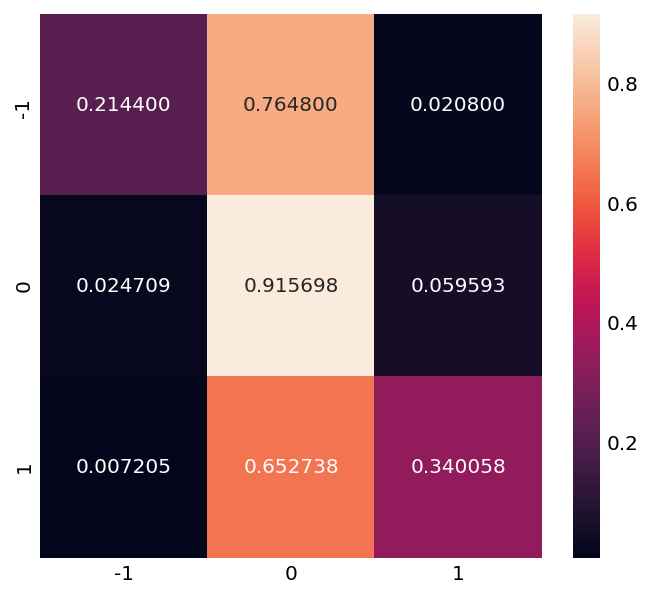

--------------------------------------------------------------------------------
Validation result for SVC RBF
SVC(C=1.0, break_ties=False, cache_size=200, class_weight='balanced', coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='scale', kernel='rbf',
    max_iter=-1, probability=False, random_state=None, shrinking=True,
    tol=0.001, verbose=False)
Average precision-recall score: 0.47
accuracy score: 63.55%


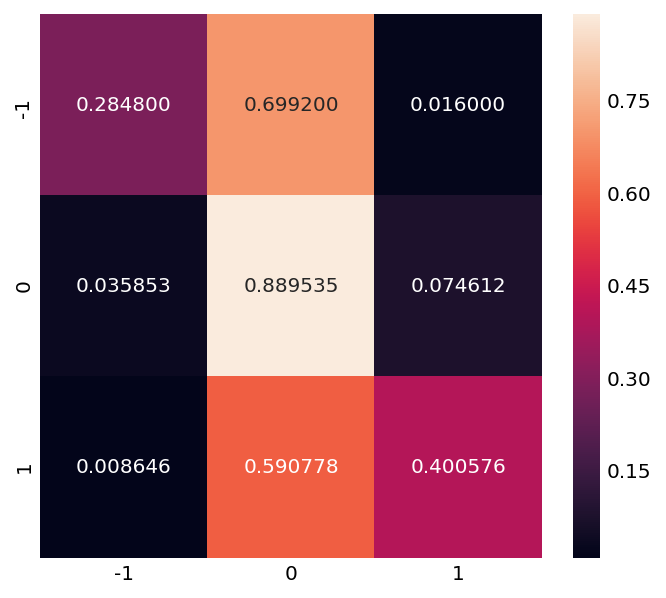

--------------------------------------------------------------------------------
Validation result for SVC RBF with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                

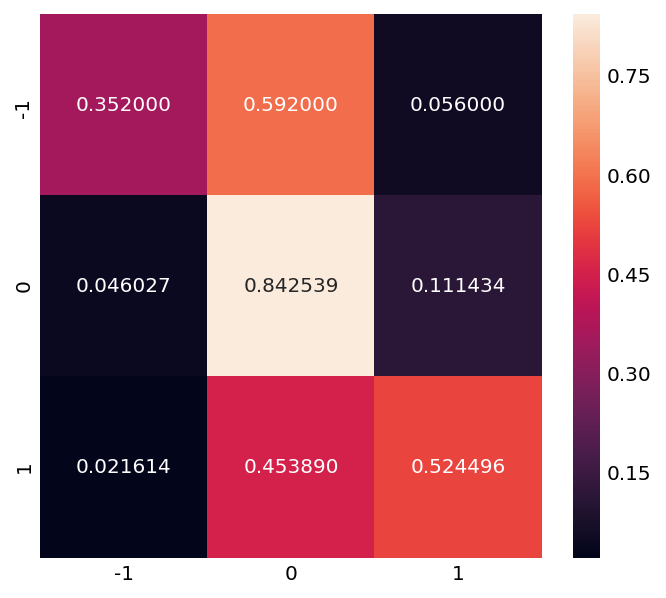

--------------------------------------------------------------------------------


In [1295]:
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.svm import LinearSVC, SVC
from sklearn.ensemble import AdaBoostClassifier, RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB, BernoulliNB
from sklearn.linear_model import RidgeClassifier, PassiveAggressiveClassifier, Perceptron, LogisticRegression
from sklearn.neighbors import NearestCentroid
from sklearn.feature_selection import SelectFromModel
from sklearn.multiclass import OneVsRestClassifier

names = ["Logistic Regression", "Linear SVC", "LinearSVC with L1-based feature selection","Multinomial NB", 
         "Bernoulli NB", "Ridge Classifier", "AdaBoost", "RandomForest", "Perceptron","Passive-Aggresive", 
         "SVC RBF", "SVC RBF with L1-based feature selection"]
classifiers = [
    LogisticRegression(class_weight='balanced', max_iter=1000),
    LinearSVC(class_weight='balanced'),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', LinearSVC(penalty="l2", class_weight='balanced'))]),
    MultinomialNB(),
    BernoulliNB(),
    RidgeClassifier(class_weight='balanced'),
    AdaBoostClassifier(),
    RandomForestClassifier(),
    Perceptron(class_weight="balanced"),
    PassiveAggressiveClassifier(class_weight='balanced'),
    SVC(class_weight='balanced'),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', SVC(class_weight='balanced'))]),
    ]
zipped_clf = zip(names,classifiers)

vec = TfidfVectorizer(min_df=0)

def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', OneVsRestClassifier(c))
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

result = classifier_comparator(n_features=100000, ngram_range=(1, 3))

Now I plot the summary of this comparison like below, namely the accuracy of each model and their average precision.

In [1302]:
import plotly.offline as py
py.init_notebook_mode(connected=True)
import plotly.graph_objs as go

import numpy as np

def bar_plot(result):
    acc=[]
    names = []
    avg_ = []
    fp_ = []
    tp_ = []

    for name, accuracy, prec, rec, avg, fp, tp in result:
        acc.append(accuracy*100)
        names.append(name)

        avg_.append(avg*100)
        fp_.append(fp)
        tp_.append(tp)
    trace1 = go.Bar(
        x=names,
        y=acc,
        name='Accuracy percentage (%)'
    )
    trace3 = go.Bar(
        x=names,
        y=avg_,
        name='Average precision (%)'
    )


    data = [trace1, trace3]
    layout = go.Layout(
        barmode='group'
    )

    fig = go.Figure(data=data, layout=layout)
    py.iplot(fig, filename='grouped-bar')
    return names, fp_, tp_

In [1303]:
names, fp_, tp_ = bar_plot(result)

We can show furthermore the performance of our classifiers by using the ROC Curve technique.

In [1306]:
def ROC_curve(names, fp, tp):
    data = []
    for i in range(0, len(names)):
        trace = go.Scatter(x=fp[i], y=tp[i],
                            mode='lines', 
                            name='ROC curve {}'
                                   ''.format(names[i]))
        data.append(trace)

    layout = go.Layout(title='Receiver operating characteristic ',
                       xaxis=dict(title='False Positive Rate'),
                       yaxis=dict(title='True Positive Rate'))

    fig = go.Figure(data=data, layout=layout)
    return fig

In [1307]:
fig = ROC_curve(names, fp_, tp_)
py.iplot(fig)

**LinearSVC with L1-based feature selection** and **SVC RBF with L1-based feature selection** have the best results. I tuned their parameters to achieve even more.

Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
               

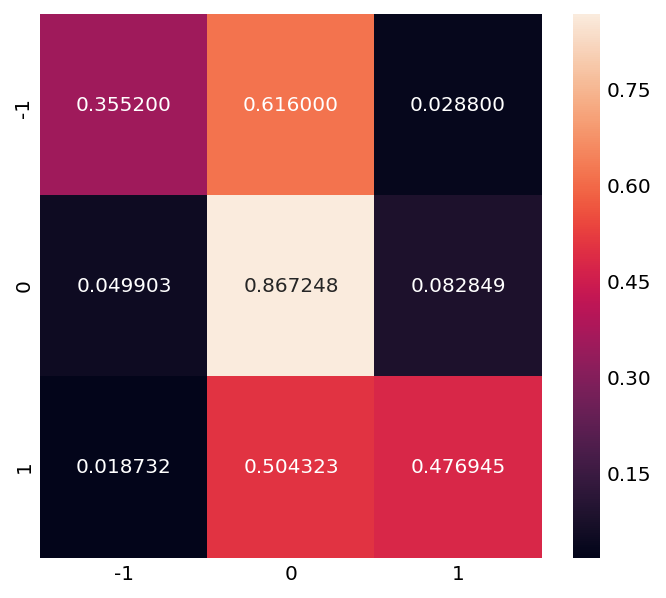

Average precision-recall score: 0.49
accuracy score: 65.33%
--------------------------------------------------------------------------------
Validation result for SVC RBF with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                 

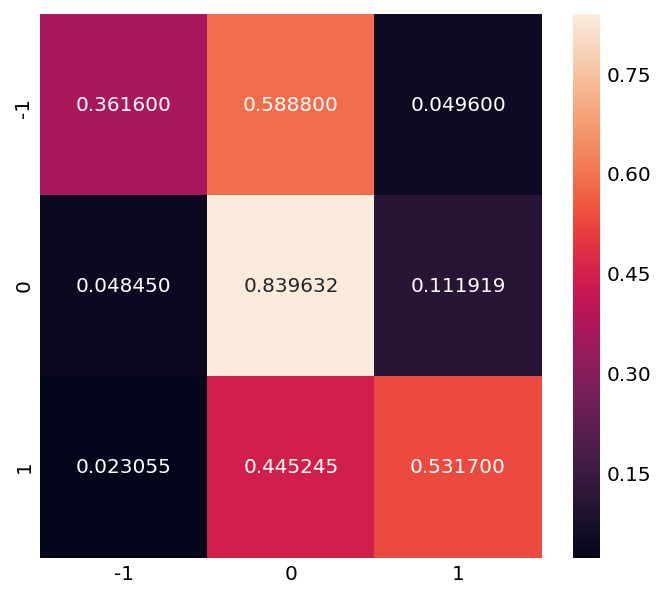

Average precision-recall score: 0.49
accuracy score: 64.85%
--------------------------------------------------------------------------------


In [1235]:
chosen_names = ["LinearSVC with L1-based feature selection", 
         "SVC RBF with L1-based feature selection"]
chosen_classifiers = [
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', LinearSVC(penalty="l2", class_weight='balanced'))]),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', SVC(class_weight='balanced'))]),
    ]
chosen_zipped_clf = zip(chosen_names, chosen_classifiers)

result = classifier_comparator(n_features=100000,ngram_range=(1,3), classifier=chosen_zipped_clf)

# Parameters tuning
Because given data depends on each other I couldn't make standard cross validation. I extracted one validation set and tuned parameters just for it. As a scoring measure I chose weighted F1 to not to descriminate smaller classes in the data.

In [1370]:
x_train_val = train[(train['set_type'] == 0) | (train['set_type'] == 1)]
y_train_val = train.sentiment[(train['set_type'] == 0) | (train['set_type'] == 1)]

indeces = x_train_val['set_type'].map(lambda x: -1 if x == 0 else 0)

x_train_val = x_train_val.tokens

print("train: ", -1 * sum(indeces), ", data:", len(indeces))

train:  28296 , data: 31679


In [1369]:
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import PredefinedSplit

vectorizer = TfidfVectorizer(min_df=0)
vectorizer.set_params(stop_words=None, max_features=100000, ngram_range=(1,3))

parameters = {'svc__estimator__kernel':('linear', 'poly', 'rbf', 'sigmoid'), 
              'svc__estimator__C':[0.5, 1, 2, 5, 10],
              'svc__estimator__gamma':('scale', 'auto', 0.1, 0.01, 0.001)}

pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
        ('svc', OneVsRestClassifier(SVC(class_weight='balanced')))])

ps = PredefinedSplit(test_fold=indeces)

search = GridSearchCV(pipe, 
                      param_grid=parameters, 
                      n_jobs=-1,
                      cv=ps,
                      verbose=1,
                      scoring='f1_weighted')
search.fit(x_train_val, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)
print(search.cv_results_)
sorted(search.cv_results_.keys())

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  34 tasks      | elapsed: 22.4min
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed: 60.8min finished


Best parameter (CV score=0.692):
{'svc__estimator__C': 0.5, 'svc__estimator__gamma': 'scale', 'svc__estimator__kernel': 'rbf'}
{'mean_fit_time': array([201.46072221, 254.2701447 , 360.54850817, 165.42275739,
       198.53433752, 247.02929997, 367.86120629, 257.58902454,
       202.07934308, 265.92324567, 332.71861887, 245.727072  ,
       209.82075357, 268.59543109, 381.04033589, 275.22487092,
       202.87172365, 277.8477385 , 401.49399185, 276.84987926,
       219.03679943, 289.66689491, 413.78159857, 164.65157771,
       222.40505457, 272.54119372, 391.13993907, 270.51932693,
       219.77651739, 267.45097709, 326.61190081, 231.97665644,
       213.82007289, 266.26775527, 361.29112148, 262.98566532,
       217.08983946, 275.52420449, 389.48518944, 266.58168578,
       209.29661083, 320.4687593 , 439.2951026 , 142.11979032,
       207.29058027, 272.75627756, 391.33745003, 270.90346813,
       224.96264482, 271.21999502, 370.57494116, 233.07252002,
       227.89137197, 271.86106515, 3

['mean_fit_time',
 'mean_score_time',
 'mean_test_score',
 'param_svc__estimator__C',
 'param_svc__estimator__gamma',
 'param_svc__estimator__kernel',
 'params',
 'rank_test_score',
 'split0_test_score',
 'std_fit_time',
 'std_score_time',
 'std_test_score']

In [1371]:
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Best parameter (CV score=0.692):
{'svc__estimator__C': 0.5, 'svc__estimator__gamma': 'scale', 'svc__estimator__kernel': 'rbf'}


In [1372]:
from sklearn.model_selection import GridSearchCV

vectorizer = TfidfVectorizer(min_df=0)
vectorizer.set_params(stop_words=None, max_features=100000, ngram_range=(1,3))

parameters = {'svc__estimator__penalty':('l1', 'l2'), 
              'svc__estimator__loss':('hinge', 'squared_hinge'),
              'svc__estimator__C':[0.5, 1, 2, 5, 10],
              'svc__estimator__max_iter':(1000, 2000, 5000, 7000, 10000),
             }

pipe = Pipeline([
        ('vectorizer', vectorizer),
        ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
        ('svc', OneVsRestClassifier(LinearSVC(class_weight='balanced')))])

ps = PredefinedSplit(test_fold=indeces)
search = GridSearchCV(pipe, 
                      param_grid=parameters, 
                      n_jobs=-1,
                      cv=ps,
                      verbose=2,
                      scoring='f1_weighted')
search.fit(x_train_val, y_train_val)
print("Best parameter (CV score=%0.3f):" % search.best_score_)
print(search.best_params_)

Fitting 1 folds for each of 100 candidates, totalling 100 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 8 concurrent workers.
[Parallel(n_jobs=-1)]: Done  25 tasks      | elapsed:   17.8s
[Parallel(n_jobs=-1)]: Done 100 out of 100 | elapsed:  2.9min finished
/home/asia/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Best parameter (CV score=0.684):
{'svc__estimator__C': 1, 'svc__estimator__loss': 'hinge', 'svc__estimator__max_iter': 1000, 'svc__estimator__penalty': 'l2'}


Tuning results are not much better than previous ones.

Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
               

/home/asia/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Average precision-recall score: 0.50
accuracy score: 64.56%


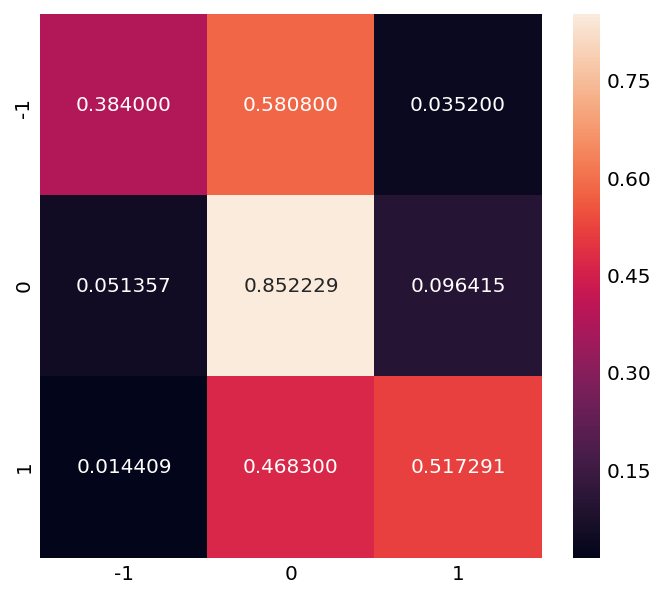

--------------------------------------------------------------------------------
Validation result for SVC RBF with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                

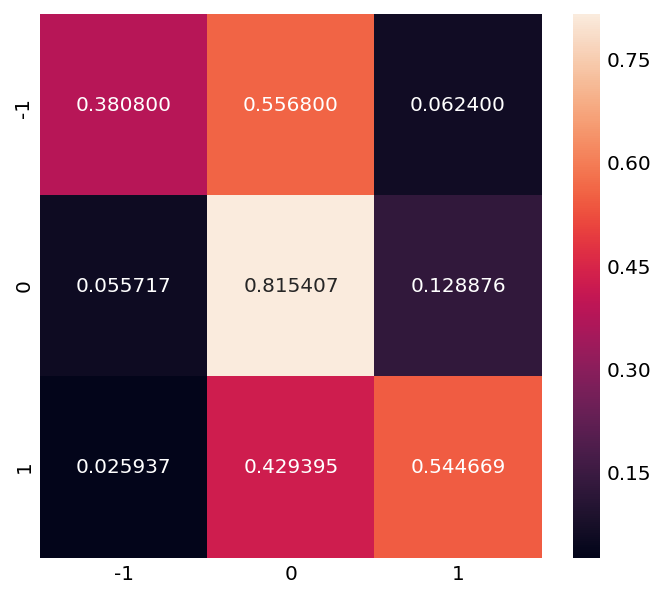

--------------------------------------------------------------------------------


In [1374]:
tuned_names = ["LinearSVC with L1-based feature selection", 
         "SVC RBF with L1-based feature selection"]
tuned_classifiers = [
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', LinearSVC(penalty="l2", class_weight='balanced', C=1, loss='hinge', max_iter=1000))]),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', SVC(C=0.5, gamma='scale', kernel='rbf', class_weight='balanced'))]),
    ]
tuned_zipped_clf = zip(tuned_names, tuned_classifiers)

def classifier_comparator(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', OneVsRestClassifier(c))
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, x_train, y_train, x_validation, y_validation)
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

tuned_result = classifier_comparator(n_features=100000,ngram_range=(1, 3), classifier=tuned_zipped_clf)

In [1375]:
tuned_names, tuned_fp, tuned_tp = bar_plot(tuned_result)

In [1376]:
tuned_fig = ROC_curve(tuned_names, tuned_fp, tuned_tp)
py.iplot(tuned_fig)

# Test results

Validation result for LinearSVC with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                                 max_features=None, norm_order=1, prefit=False,
               

/home/asia/venv/lib/python3.6/site-packages/sklearn/svm/_base.py:947: ConvergenceWarning:

Liblinear failed to converge, increase the number of iterations.



Average precision-recall score: 0.47
accuracy score: 62.07%


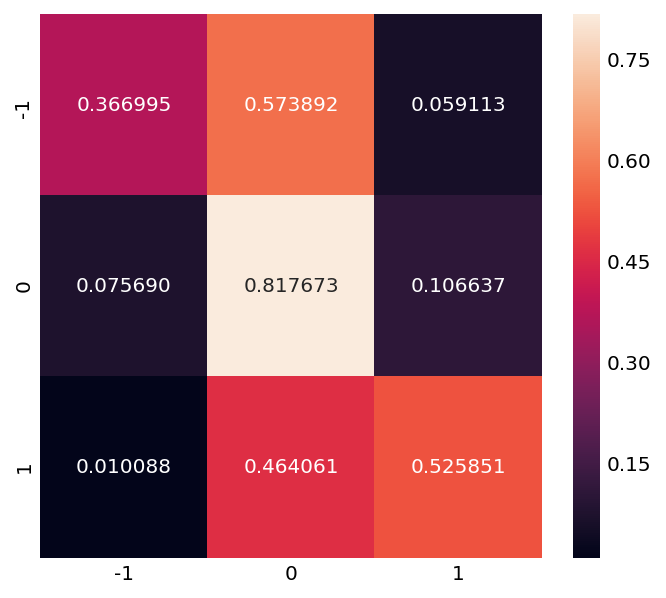

--------------------------------------------------------------------------------
Validation result for SVC RBF with L1-based feature selection
Pipeline(memory=None,
         steps=[('feature_selection',
                 SelectFromModel(estimator=LinearSVC(C=1.0,
                                                     class_weight='balanced',
                                                     dual=False,
                                                     fit_intercept=True,
                                                     intercept_scaling=1,
                                                     loss='squared_hinge',
                                                     max_iter=1000,
                                                     multi_class='ovr',
                                                     penalty='l1',
                                                     random_state=None,
                                                     tol=0.0001, verbose=0),
                

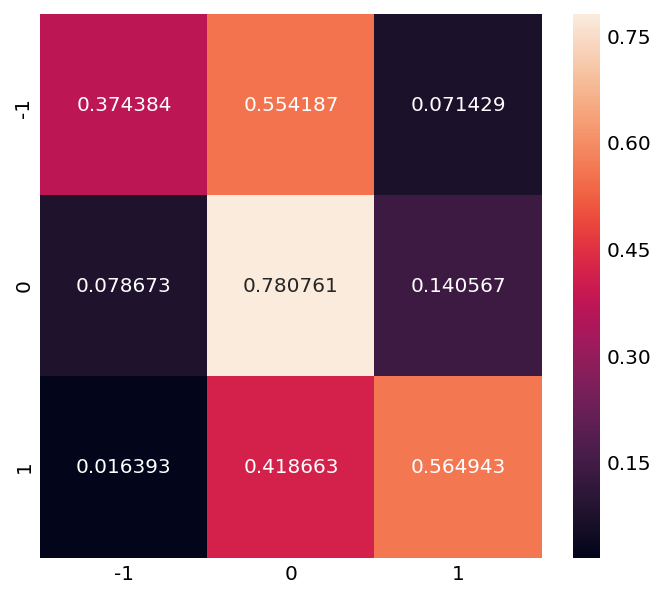

--------------------------------------------------------------------------------


In [1378]:
tuned_names = ["LinearSVC with L1-based feature selection", 
         "SVC RBF with L1-based feature selection"]
tuned_classifiers = [
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', LinearSVC(penalty="l2", class_weight='balanced', C=1, loss='hinge', max_iter=1000))]),
    Pipeline([
  ('feature_selection', SelectFromModel(LinearSVC(penalty="l1", dual=False, class_weight='balanced'))),
  ('classification', SVC(C=0.5, gamma='scale', kernel='rbf', class_weight='balanced'))]),
    ]
tuned_zipped_clf = zip(tuned_names, tuned_classifiers)

def classifier_comparator_2(vectorizer=vec, n_features=10000, stop_words=None, ngram_range=(1, 1), classifier=zipped_clf):
    result = []
    vectorizer.set_params(stop_words=stop_words, max_features=n_features, ngram_range=ngram_range)
    for n,c in classifier:
        checker_pipeline = Pipeline([
            ('vectorizer', vectorizer),
            ('classifier', OneVsRestClassifier(c))
        ])
        print ("Validation result for {}".format(n))
        print (c)
        clf_acc, prec, rec, avg, fp, tp = acc_summary(checker_pipeline, 
                                                      train[train['set_type'] != 2].tokens, 
                                                      binary_sentiment[train['set_type'] != 2], 
                                                      train[train['set_type'] == 2].tokens, 
                                                      binary_sentiment[train['set_type'] == 2])
        result.append((n,clf_acc,prec, rec, avg, fp, tp))
    return result

tuned_result = classifier_comparator_2(n_features=100000,ngram_range=(1, 3), classifier=tuned_zipped_clf)

Test results very well reflect the results of previous simulations. Accuracy 62% and average precision-recall score equal to 47% are not good results. For further improvements I could try to augment data, to create more negative/positive samples. Right now the disproportion between the classes is harmful for the model. Also 2700 unique samples is not that much for language research. More samples would make an addition of phrases and words and improve model performance. The other thing which could be done is feature selection tuning.